In [1]:
import sys
import os
import numpy as np
import torch
from torch import _linalg_utils as _utils, Tensor
import tensorly as tl
tl.set_backend('pytorch')

# Add the project root directory to sys.path
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(project_root)

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)


In [2]:
if torch.cuda.is_available():
    print("GPU is available:", torch.cuda.get_device_name(0))
else:
    print("No GPU detected. Check your CUDA installation.")

No GPU detected. Check your CUDA installation.


In [3]:
from sensor_placement.utils  import Tensorization, Matrixization, extract_subtensor, compute_info_gain, load_tensor,matrixize_numpy_array, plot_histogram_relError
from sensor_placement.decomposition import  TuckerOEDSelection, ScketchThenTuckerOEDSelection
from sensor_placement.tests import run_oed_methods,  benchmark_oed_methods

In [4]:
#A = load_tensor("Ah.npy", sub_folder="flow")  # same as A = Matrixization(X) 
Xtr = load_tensor("uctrain.npy", sub_folder="flow") # X = Tensorization(A,shape= X.shape)
A = matrixize_numpy_array(Xtr) 
print("shape A", A.shape)
print("Shape tensor X:", Xtr.shape)

File was found inside the subfolder inside 'data'. 
shape A (150, 810000)
Shape tensor X: (150, 90, 60, 150)


In [5]:
compute_info_gain(A)

680.7954

In [6]:
m1,m2,m3,nt = Xtr.shape
print(f"# mode 1: {m1}, # mode 2: {m2},# mode 3: {m3}, # snapshots: {nt}")

# mode 1: 150, # mode 2: 90,# mode 3: 60, # snapshots: 150


In [7]:
k = 5
#Number of target sensors 
k1 = k
k2 = k
k3 = k
Pi = np.arange(Xtr.ndim-1) # processing order (0,1,2,...) change according to problem.  (last dimension avoided)
target_rank = (k1, k2, k3) # , X.shape[-1]
K = np.prod(target_rank)

In [8]:
X = tl.tensor(Xtr).clone() 

In [9]:
# Random Designs 
nsamples = 2000
OED_values = np.zeros(nsamples)  # Initialize an array of zeros

for rr in range(nsamples):  # Loop over the range 1 to nsamples
    S_listR = []
    ir1 = np.random.permutation(m1)[:k1]   
    ir2 = np.random.permutation(m2)[:k2] 
    ir3 = np.random.permutation(m3)[:k2]  
    S_listR.append(ir1)
    S_listR.append(ir2)
    S_listR.append(ir3)
    subtensor =  extract_subtensor(X, S_listR, Pi)
    unfolded =  Matrixization(subtensor)
    OED_values[rr] = compute_info_gain(unfolded)

In [10]:
flagSketchA = False
if flagSketchA:
    p = 10 # oversampling 
    n =  A.shape[0]
    d2 = K + p
    mu, sigma = 0, 1/np.sqrt(d2) # mean and standard deviation. TODO check 
    sketchA = np.random.normal(mu, sigma, (d2, n)) @ A
    EIG_sketch = compute_info_gain(sketchA)
    print("Sketch EIG (all sensors)", EIG_sketch) 
    shape_sketchX  = list(X.shape) # TODO fix this 
    shape_sketchX[-1] = d2
    sketchX = Tensorization(sketchA ,shape= shape_sketchX) 
    print("Tensor Shape X", X.shape)
    print("Tensor Shape after sketch", sketchX.shape)
    X1 = tl.tensor(sketchX)
else:
    X1 = tl.tensor(X)
    print("Tensor Shape X", X.shape)

Tensor Shape X torch.Size([150, 90, 60, 150])


Method: IndSelect
Selected Indices for mode: 0
[ 38  48  59  74 100]
Selected Indices for mode: 1
[50 54 44 36 27]
Selected Indices for mode: 2
[ 0  7 13 20 29]
EIG: 95.89165
Method: SeqSelect
Selected Indices for mode: 0
[ 38  48  59  74 100]
Selected Indices for mode: 1
[53 49 44 37 28]
Selected Indices for mode: 2
[ 0  7 13 20 27]
EIG: 97.793945
Method: IterSelect
Selected Indices for mode: 0
[49 38 58 67 84]
Selected Indices for mode: 1
[53 49 43 26 35]
Selected Indices for mode: 2
[ 0  7 13 20 27]
EIG: 99.87038


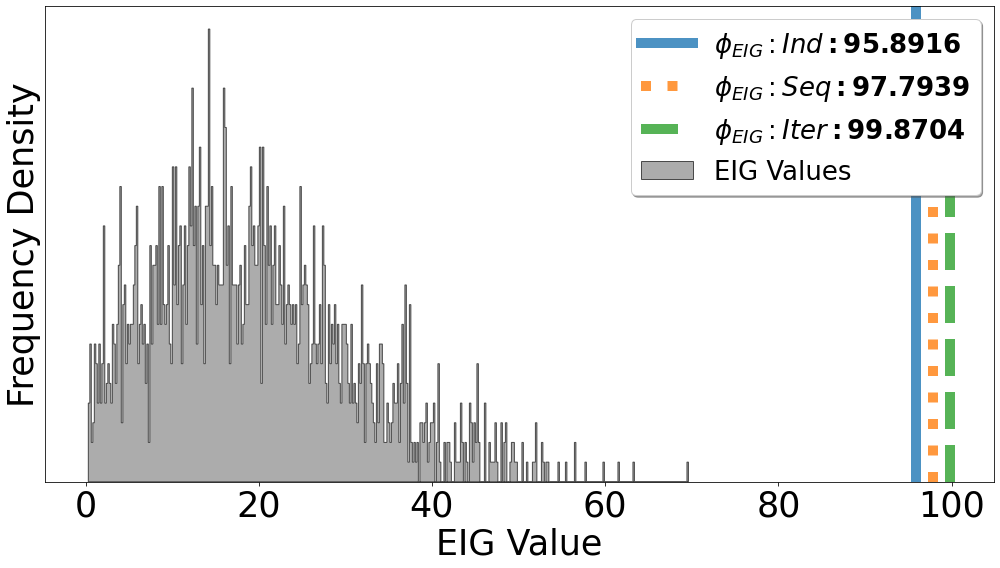

In [11]:
methods =  ["IndSelect", "SeqSelect", "IterSelect"]

# Run the function
indices_dict = run_oed_methods(
    X=X1,
    X1=X,
    target_rank=target_rank,
    Pi=Pi,
    methods=methods,
    plot=True,  # Set to True if you want to plot the results
    OED_values=OED_values,
    k=k,
    loc= 'upper right',
    show_title=False,
    bins= nsamples//5 #'auto' # 2*nsamples//3
)

In [12]:
timesSelec =benchmark_oed_methods(X1, target_rank=target_rank, Pi=Pi, methods=["IndSelect", "SeqSelect", "IterSelect"], greedy_approach=False, n_runs=3) 

Avg time for IndSelect: 13.9135 seconds
Avg time for SeqSelect: 4.0329 seconds
Avg time for IterSelect: 2.0405 seconds
